In [1]:
import datashader as ds
from datashader import transfer_functions as tf

import numpy as np
import pandas as pd
from scipy import sparse
import xarray as xr

import scanpy as sc

# Preping data

In [2]:
adata = sc.read("/Users/isaac/data/10x_mouse_13MM_processed.h5ad", backed="r")

/Users/isaac/github/anndata/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/isaac/github/anndata/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
adata

AnnData object with n_obs × n_vars = 1305994 × 972 backed at '/Users/isaac/data/10x_mouse_13MM_processed.h5ad'
    obs: 'n_counts_all', 'n_counts', 'louvain', 'n_genes'
    var: 'gene_ids', 'n_counts', 'n_cells'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
N = 500  # pixels per axis

In [5]:
df = sc.get.obs_df(
    adata,
    ["Sox17", "louvain"],
    obsm_keys=[("X_umap", 0), ("X_umap", 1)]
)
louvain_colors = dict(
    zip(
        adata.obs["louvain"].cat.categories, 
        adata.uns["louvain_colors"]
    )
)
pts = (
    ds.Canvas(N, N)
    .points(df, "X_umap-0", "X_umap-1", agg=ds.count_cat("louvain"))
)

## Base plot

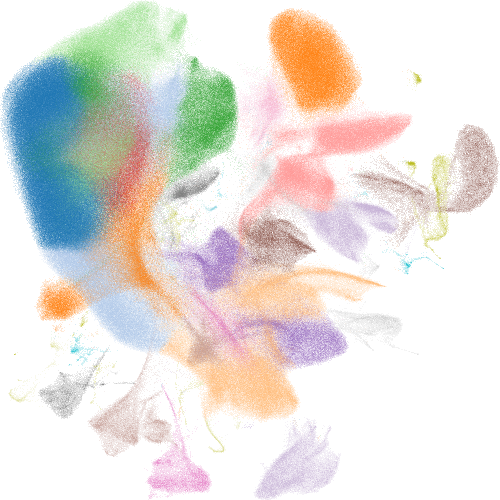

In [6]:
color_by_cluster = tf.shade(pts, color_key=louvain_colors)
color_by_cluster

# Where clusters overlap

In [7]:
pts_ncats = (pts != 0).sum(axis=2)

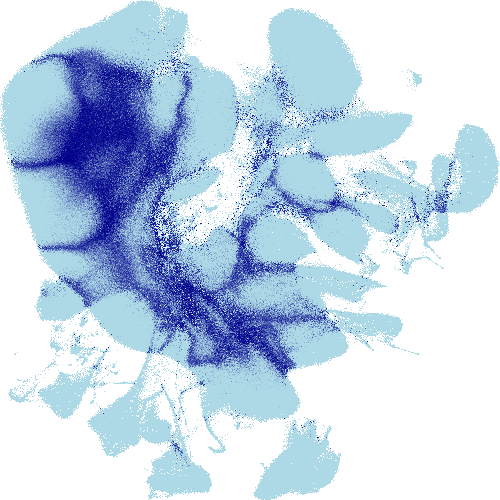

In [8]:
tf.shade(pts.sum(axis=2) / pts.max(axis=2))

In [9]:
def diagonal_bands_like(arr, width=3):
    assert arr.ndim == 2
    a = np.zeros_like(arr, dtype=bool)
    step = a.shape[1] + 1
    # Not sure why end isn't making a difference
    end = None
#     end = a.shape[1] * a.shape[1]
    fill = True
    for i in range(arr.shape[0]):
        if (i + width // 2) % width == 0:
            fill = not fill
        if fill:
            a.flat[i:end:step] = True
    return a

In [10]:
pts_ncats = (pts != 0).sum(axis=2)
overlap_idx = pts_ncats == 1
zebra_source = xr.DataArray(
    diagonal_bands_like(overlap_idx, 13),
    coords=overlap_idx.coords
)


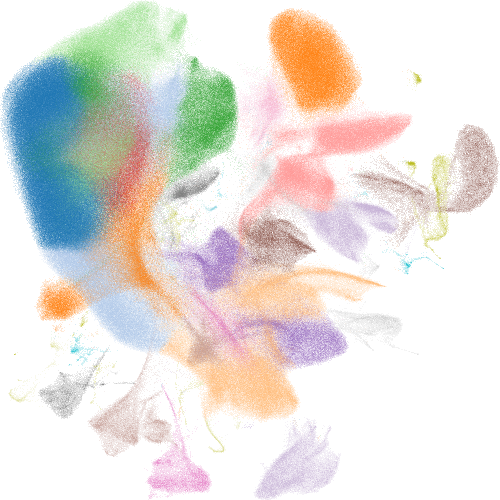
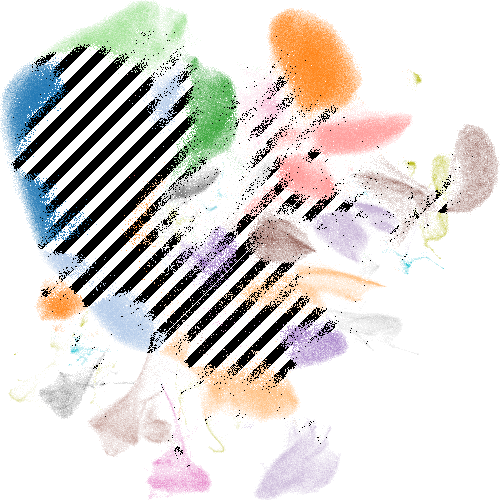
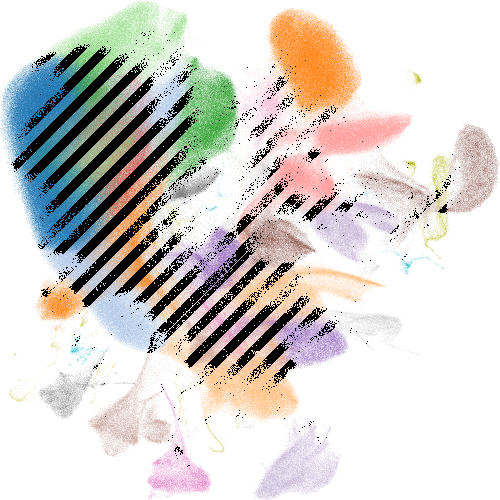

In [11]:
tf.Images(
    color_by_cluster,
    tf.stack(
        tf.Image(xr.where(pts_ncats == 1, color_by_cluster, 0)),
        tf.Image(tf.shade(xr.where(pts_ncats > 1, zebra_source, False), cmap="black"))
    ),
    tf.stack(
        color_by_cluster,
        tf.Image(tf.shade(xr.where(pts_ncats > 1, zebra_source, False), cmap="black"))
    ),
)

# Extra/ scratch

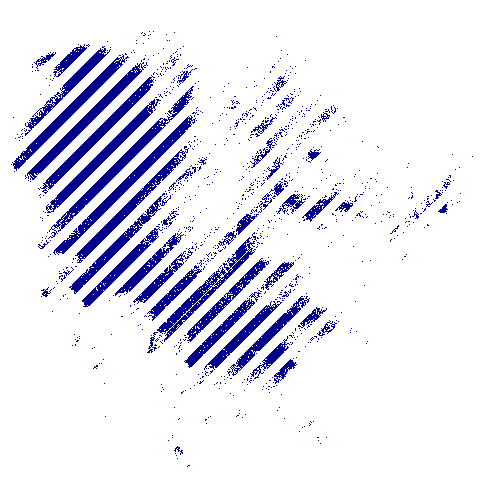

In [12]:
tf.shade(xr.where(pts_ncats > 1, zebra_source, False))

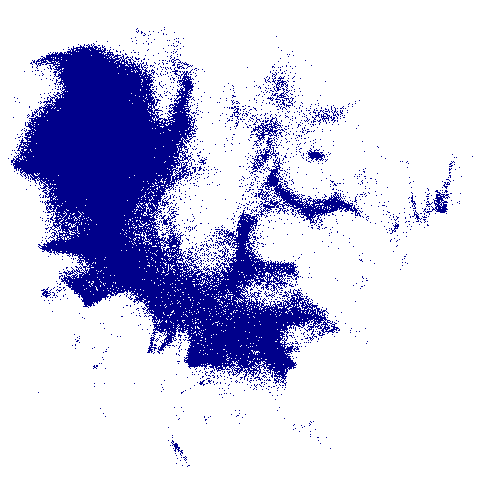

In [13]:
tf.shade(((pts != 0).sum(axis=2) > 1))

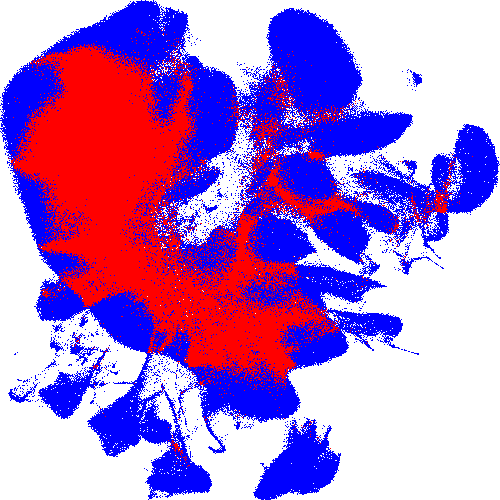

In [14]:
tf.stack(
    tf.shade(((pts != 0).sum(axis=2) == 1), cmap="blue"),
    tf.shade(((pts != 0).sum(axis=2) > 1), cmap="red")
)

# Spreading


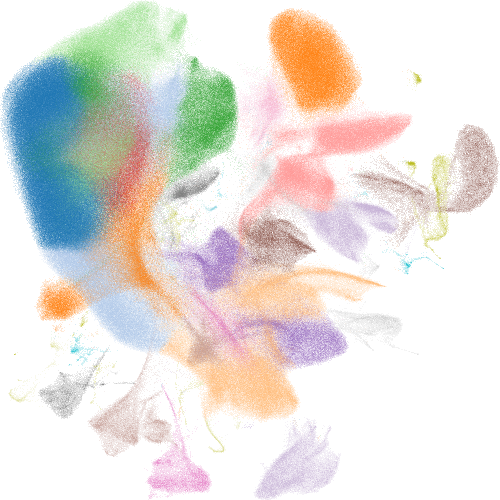
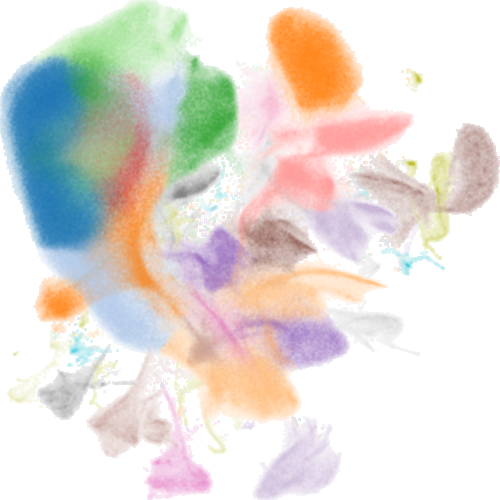
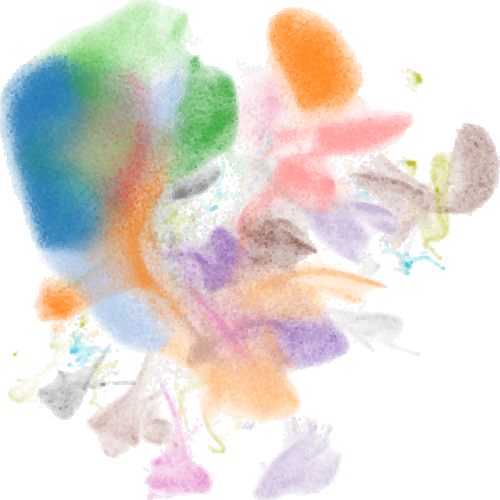
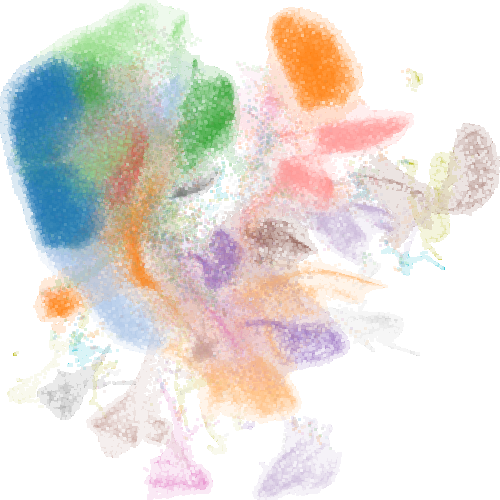
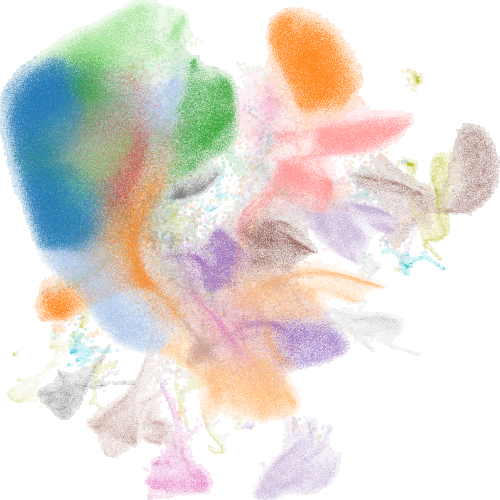

In [15]:
pt_ops = ['add', 'max', 'min', 'source']
tf.Images(
    tf.shade(pts, color_key=louvain_colors),
    *(tf.shade(tf.spread(pts, how=op), color_key=louvain_colors, name=op) for op in pt_ops)
)


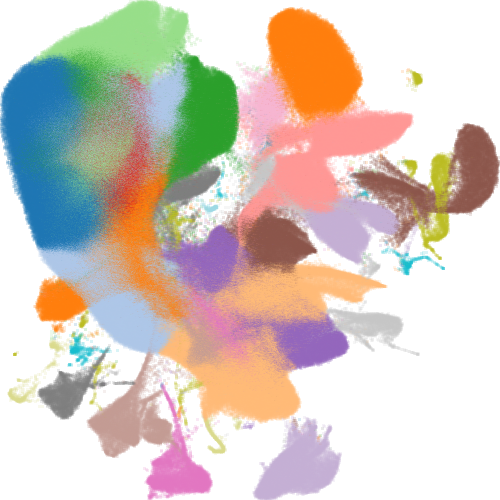
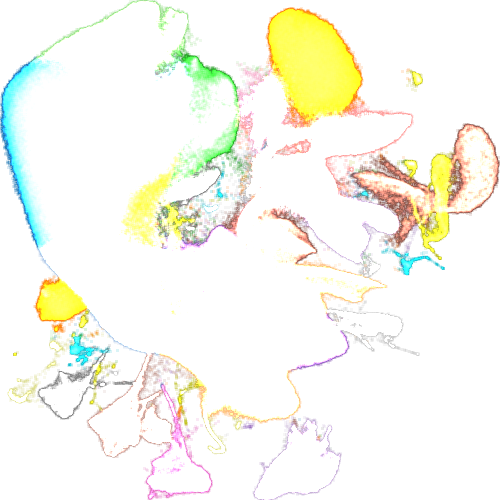
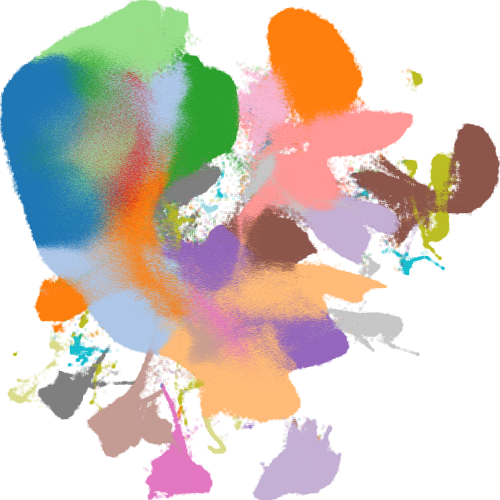
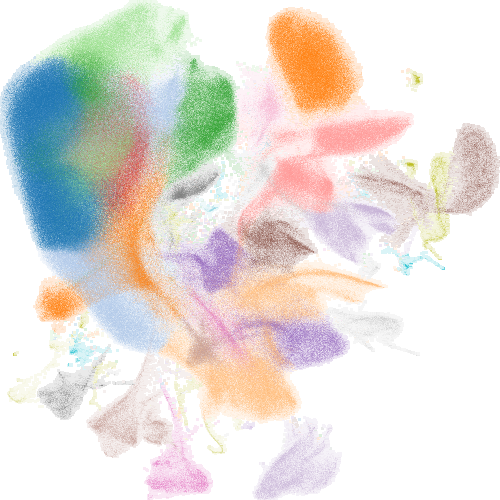

In [16]:
im_ops = ['over', 'add', 'saturate', 'source']

tf.Images(
    *(tf.spread(tf.shade(pts, color_key=louvain_colors, name=op), how=op) for op in im_ops)
)